# **1. Project Overview**

### *Project Description*
In this project, we will build a deep learning model using a Recurrent Neural Network (RNN) to perform sentiment analysis on movie reviews. The goal of the project is to predict the number of positive and negative movie reviews using this deep learning algorithm on a dataset of 50,000 movie reviews from IMDB.

### *Project Objectives*
- Develop a sentiment analysis model capable of accurately classifying movie reviews into positive and negative categories.
- Provide a user-friendly interface for users to input movie reviews and obtain sentiment predictions.
- Document the project's methodology, results, and any challenges faced during the development process.
- Explore the potential for model deployment to enable real-time sentiment analysis for movie reviews.

### *Dataset Description*
The [**IMDB Large Movie Review Dataset**](http://ai.stanford.edu/~amaas/data/sentiment/) is a dataset for binary sentiment classification compiled from a collection of 50,000 reviews from IMDB.

In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels.  In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.

The dataset contains movie reviews along with their associated binary sentiment polarity labels. The 50,000 reviews are divided evenly into the training and test set, with 25,000 highly polar movie reviews for training, and 25,000 for testing.

***Data Format:***<br>
    - `review`: The movie review text, consisting of user-written reviews.<br>
    - `sentiment`: The sentiment label, which is binary and can be either "positive" or "negative."
    
---

# **2. Project Setup**

In [133]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [134]:
# IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import re
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [135]:
# SET NOTEBOOK FORMATTING OPTIONS
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]

In [136]:
# READ IN DATA
df = pd.read_csv('../input/imdb-movie-reviews-deep-learning/IMDB Dataset.csv')

---

# **3. Exploratory Data Analysis (EDA)**

In [137]:
# Preview data
display(df)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### **3.1 Missing Values**

In [139]:
# Null data check
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [140]:
# Empty data check
any((df['review'] == ' ') | (df['sentiment'] == ' '))

False

### **3.2 `sentiment` Variable**

In [141]:
# Check unique values
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

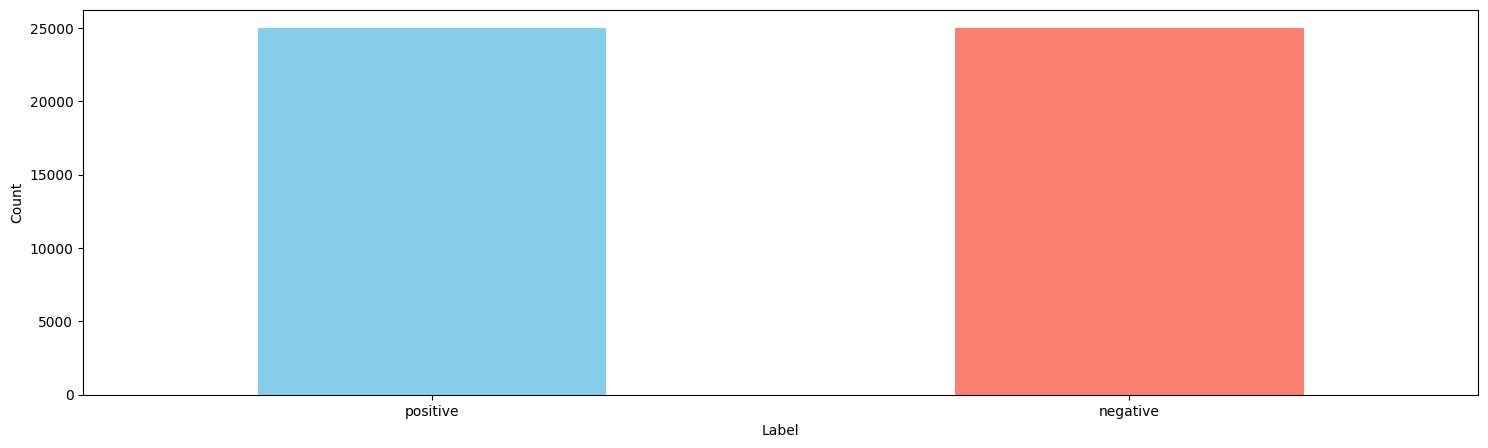

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [142]:
# Plot distribution of labels: should be equal (25000)
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

print(df['sentiment'].value_counts()) # print value counts

### **3.3 Keywords**
Top 10 keywords in positive and negative reviews.

In [143]:
# Subset positive and negative reviews
pos_reviews = df['review'][df['sentiment']=='positive'] # Positive
neg_reviews = df['review'][df['sentiment']=='negative'] # Negative

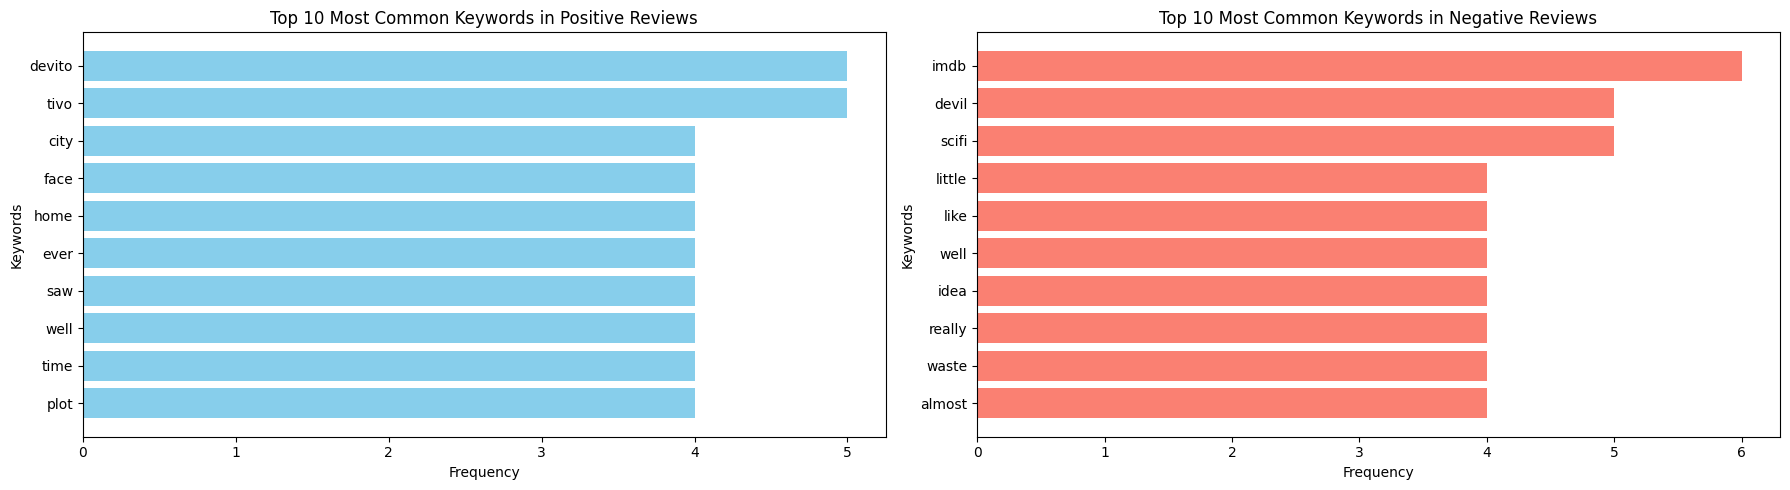

In [144]:
# Plot top 10 most common keywords in positive and negative reviews
plt.figure(figsize=(18, 5))

# POSITIVE REVIEWS
plt.subplot(1, 2, 1)

# Tokenize reviews and count word frequencies
words = FreqDist(word_tokenize(' '.join(pos_reviews)))
filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
word_freq = FreqDist(filtered_words)

# Extract top most common keywords
top_n = 10
top_keywords = word_freq.most_common(top_n)
keywords, counts = zip(*top_keywords)

# Plot top 10 most common keywords
plt.barh(keywords, counts, color='skyblue')
plt.gca().invert_yaxis()
plt.title(f'Top {top_n} Most Common Keywords in Positive Reviews')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.tight_layout()

###

# NEGATIVE REVIEWS
plt.subplot(1, 2, 2)

# Tokenize reviews and count word frequencies
words = FreqDist(word_tokenize(' '.join(neg_reviews)))
filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
word_freq = FreqDist(filtered_words)

# Extract top most common keywords
top_n = 10
top_keywords = word_freq.most_common(top_n)
keywords, counts = zip(*top_keywords)

# Plot top 10 most common keywords
plt.barh(keywords, counts, color='salmon')
plt.gca().invert_yaxis()
plt.title(f'Top {top_n} Most Common Keywords in Negative Reviews')
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.tight_layout()

plt.tight_layout()

### **3.4 Distribution of Word Counts**

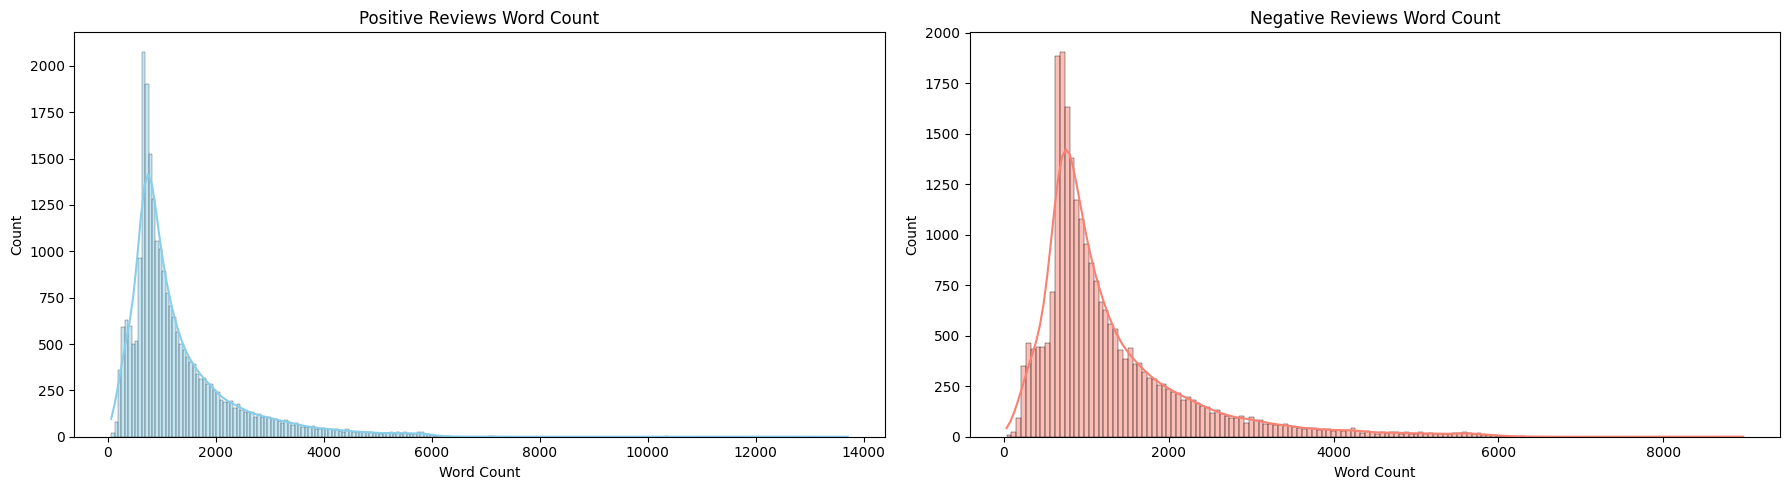

In [145]:
# Plot distribution of word counts
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
sns.histplot(pos_reviews.str.len(), color='skyblue', kde=True)
plt.title('Positive Reviews Word Count')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
sns.histplot(neg_reviews.str.len(), color='salmon', kde=True)
plt.title('Negative Reviews Word Count')
plt.xlabel('Word Count')

plt.tight_layout()

### **3.5 Word Clouds**

**Positive Reviews Word Cloud**

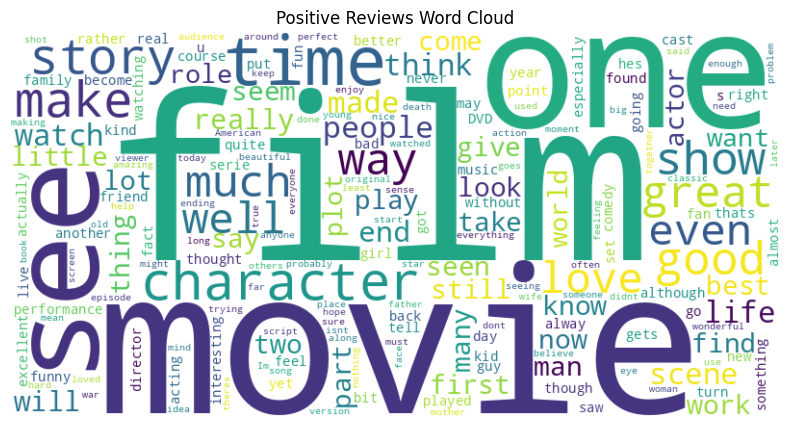

In [146]:
# Positive reviews word cloud
words = ' '.join(pos_reviews)
words = re.sub(r'<.*?>', ' ', words) # remove HTML tags
words = re.sub(r'[^A-Za-z\s]', '', words) # remove non-alphanumeric characters except spaces

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

**Negative Reviews Word Cloud**

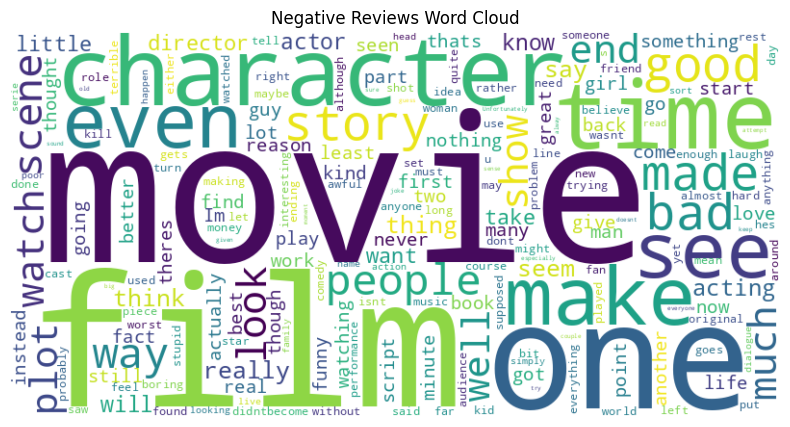

In [147]:
# Negative reviews word cloud
words = ' '.join(neg_reviews)
words = re.sub(r'<.*?>', ' ', words) # remove HTML tags
words = re.sub(r'[^A-Za-z\s]', '', words) # remove non-alphanumeric characters except spaces

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

---

# **4. Preprocessing**

### **4.1 Encode Labels**

In [148]:
# Separate X and y
X = df['review']
y = df['sentiment']

In [149]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)
y

array([1, 1, 1, ..., 0, 0, 0])

### **4.2 Tokenize**

In [150]:
# Prepare data
max_words = 10000 # Vocabulary size (number of most frequent words to keep)
max_sequence_length = 200 # Maximum sequence length

In [151]:
# Tokenize
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

### **4.3 Training, Validation, and Testing Data**

In [152]:
# Training Data
X_train, y_train = X_padded[:8000], y[:8000]

In [153]:
# Validation Data
X_val, y_val = X_padded[8000:9000], y[8000:9000]

In [154]:
# Testing Data
X_test, y_test = X_padded[9000:], y[9000:]

---

# **5. Model Building**
Construct RNN model using Keras Sequential API. The model includes:
- An Embedding layer that converts the integer-encoded words into dense vectors of fixed size.
- An LSTM (Long Short-Term Memory) layer, which is a type of recurrent layer capable of capturing sequential information.
- A Dense output layer with a sigmoid activation function for binary classification.

In [155]:
model = keras.Sequential([
    keras.layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_sequence_length),
    keras.layers.LSTM(64),
    keras.layers.Dense(1, activation='sigmoid')
])

Compile the model with the Adam optimizer, binary cross-entropy loss (appropriate for binary classification), and accuracy as the evaluation metric.

In [156]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

---

# **6. Model Training**

Train the model on the training data. Specify the number of training epochs (30 in this case), batch size, and use the validation data to monitor the model's performance during training.

In [157]:
model_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

Epoch 1/30
250/250 [==============================] - 24s 87ms/step - loss: 0.6932 - accuracy: 0.5058 - val_loss: 0.6913 - val_accuracy: 0.5410
Epoch 2/30
250/250 [==============================] - 21s 86ms/step - loss: 0.6774 - accuracy: 0.5744 - val_loss: 0.6895 - val_accuracy: 0.5360
Epoch 3/30
250/250 [==============================] - 21s 85ms/step - loss: 0.6564 - accuracy: 0.6140 - val_loss: 0.6819 - val_accuracy: 0.5880
Epoch 4/30
250/250 [==============================] - 21s 85ms/step - loss: 0.5792 - accuracy: 0.6883 - val_loss: 0.6884 - val_accuracy: 0.5810
Epoch 5/30
250/250 [==============================] - 21s 85ms/step - loss: 0.5255 - accuracy: 0.7582 - val_loss: 0.6332 - val_accuracy: 0.6780
Epoch 6/30
250/250 [==============================] - 21s 85ms/step - loss: 0.5293 - accuracy: 0.7598 - val_loss: 0.6897 - val_accuracy: 0.5470
Epoch 7/30
250/250 [==============================] - 22s 86ms/step - loss: 0.4642 - accuracy: 0.7933 - val_loss: 0.6804 - val_accuracy:

In [158]:
print('Best Training Loss: ', min(model_history.history['loss']), ' (Epoch ', np.argmin(model_history.history['loss']), ')', sep='') # smallest training loss
print('Best Training Accuracy: ', max(model_history.history['accuracy']), ' (Epoch ', np.argmax(model_history.history['accuracy']), ')', sep='') # highest training accuracy

print('Best Validation Loss: ', min(model_history.history['val_loss']), ' (Epoch ', np.argmin(model_history.history['val_loss']), ')', sep='') # smallest validation loss
print('Best Validation Accuracy: ', max(model_history.history['val_accuracy']), ' (Epoch ', np.argmax(model_history.history['val_accuracy']), ')', sep='') # highest validation accuracy

Best Training Loss: 0.028486473485827446 (Epoch 29)
Best Training Accuracy: 0.9944999814033508 (Epoch 29)
Best Validation Loss: 0.5783095359802246 (Epoch 16)
Best Validation Accuracy: 0.8080000281333923 (Epoch 28)


### **6.1 Predictions**

In [159]:
predictions = model.predict(X_test)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

1282/1282 [==============================] - 36s 28ms/step


In [160]:
# Display sample predictions
for i in range(10):
    print(f"Review: {X_test[i]}")
    print(f"Predicted Sentiment: {'Positive' if binary_predictions[i] == 1 else 'Negative'}")
    print()

Review: [  12   18  508    6  250    6   27  138   13   45   22    4   50   18
   10  488   23    6   27 4254   37    1    6  128   19 1005   37   51
   10  538    6   77  219   10  754  990    3  338   40 1401    2  273
  412   23   48 2311    5   40   49    7  167   21   19   10  155    8
    8    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    

---

# **7. Performance Metrics**

- Validation Accuracy
- Test Accuracy
- ROC AUC Score
- Confusion Matrix

### **7.1 Validation Accuracy**
The validation accuracy monitors how well the model is performing on a separate dataset (validation data) during training and assess its ability to generalize to unseen data. Validation accuracy helps ensure that the model is well-tuned and performs optimally on unseen data, enhancing its reliability and generalization to real-world applications.

In [161]:
val_acc = model_history.history['val_accuracy']

print(f"Validation accuracy: {val_acc[-1]:.4f}")

Validation accuracy: 0.8020


The model has a validation accuracy of **0.8020.** This means that, during the training phase, the model correctly predicted the sentiment of approximately 80.20% of the movie reviews in the validation dataset.

This indicates that the model is performing reasonably well on data that it hasn't seen during training. It suggests that the model is learning to generalize to some extent and make reasonably accurate predictions on unseen movie reviews.

### **7.2 Test Accuracy**
Test accuracy is a straightforward metric to assess the model's overall performance in correctly classifying sentiment in IMDB movie reviews, and offers a clear measure of its effectiveness in making accurate predictions on unseen data.

In [162]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_acc:.4f}")

1282/1282 [==============================] - 36s 28ms/step - loss: 0.8530 - accuracy: 0.7988
Test accuracy: 0.7988


The model has a test accuracy of **0.7988.** This means that our sentiment analysis model correctly predicted the sentiment of approximately 79.88% of the moview reviews in the test dataset.

A test accuracy of 0.7988 indicates that the model is performing significatly better than random guessing but may still have room for improvement.

### **7.3 ROC AUC Score**
The ROC AUC score estimates the confidence of predictions and assesses the model's ability to distinguish between positive and negative sentiments. It evaluates the trade-off between true positive and false positive rates at various thresholds.

In [163]:
roc_auc = roc_auc_score(y_test, predictions)

print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8574


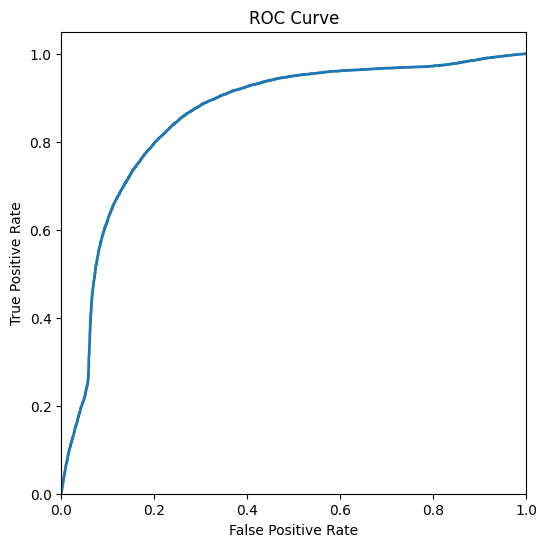

In [164]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, predictions)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The ROC AUC score is **0.8574.** This means that the sentiment analysis model has strong discriminatory power and is effective at distinguishing between positive and negative sentiments in the IMDb movie reviews dataset. It's significantly better than random guessing (where ROC AUC would be close to 0.5) but may still have room for further improvement.

### **7.4 Confusion Matrix**
Examining the confusion matrix can provide insights into where the model is making errors. It breaks down the predictions into true positives, true negatives, false positives, and false negatives, allowing us to see which types of errors are more prevalent.

In [165]:
cm = confusion_matrix(y_test, binary_predictions)

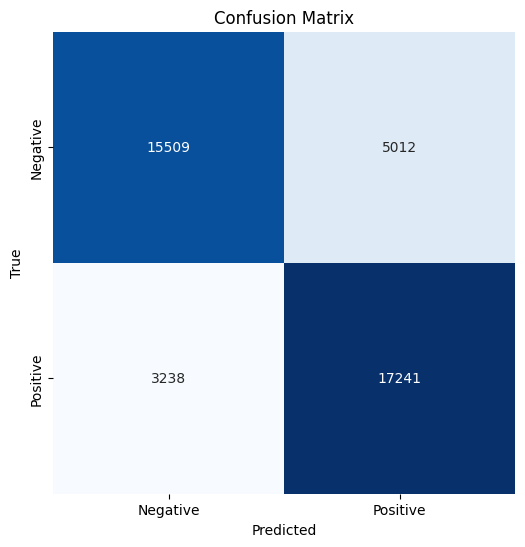

In [166]:
# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that there are:

- **True Positives (17,241):** These are instances where the model correctly predicted positive sentiment (e.g., correctly identifying positive movie reviews as positive).

- **True Negatives (15,509):** These are instances where the model correctly predicted negative sentiment (e.g., correctly identifying negative movie reviews as negative).

- **False Positives (5,012):** These are instances where the model incorrectly predicted positive sentiment when the actual sentiment was negative (e.g., incorrectly classifying negative movie reviews as positive). False positives represent Type I errors.

- **False Negatives (3,238):** These are instances where the model incorrectly predicted negative sentiment when the actual sentiment was positive (e.g., incorrectly classifying positive movie reviews as negative). False negatives represent Type II errors.

The model is reasonably effective at correctly classifying both positive and negative sentiments in movie reviews, as indicated by a substantial number of true positives and true negatives. However, there is room for improvement in precision (minimizing false positives) and recall (minimizing false negatives). The model occasionally misclassifies negative reviews as positive and fails to recognize positive sentiment in some reviews.

---

# **8. Results and Conclusion**

<h2><span style="color:#00008B; font-weight:bold;">Results</span></h2>


After training and evaluating the sentiment analysis model on IMDb movie reviews, we obtained the following performance metrics:

- **Validation Accuracy:** The model achieved a validation accuracy of 0.8020, indicating its ability to make accurate predictions on previously unseen data from the validation dataset. This metric is a crucial indicator of the model's generalization performance.

- **Test Accuracy:** On the test dataset, the model demonstrated a test accuracy of 0.7988. This performance metric confirms the model's ability to classify movie reviews into positive and negative sentiments, suggesting that it can effectively generalize to real-world scenarios.

- **ROC AUC Score:** The ROC AUC score, a measure of the model's discriminatory power, was calculated to be 0.8574. This score indicates that the model excels at distinguishing between positive and negative sentiments in movie reviews. A higher ROC AUC score is indicative of better classification performance.

**Interpretation:**<br>
The achieved performance metrics demonstrate the effectiveness of our sentiment analysis model on IMDb movie reviews. With a validation accuracy of 0.8020 and a test accuracy of 0.7988, the model consistently performs well on both the validation and test datasets, suggesting its robustness in classifying sentiments.

Furthermore, the ROC AUC score of 0.8574 highlights the model's strong discriminatory power, signifying its ability to make reliable predictions and differentiate between positive and negative sentiments. This performance metric underscores the practical utility of the model in various applications, including sentiment analysis in the film industry and market research.

These results collectively indicate that our sentiment analysis model is capable of accurately categorizing IMDb movie reviews, making it a valuable tool for understanding user sentiments and aiding decision-making processes.

<h2><span style="color:#00008B; font-weight:bold;">Conclusion</span></h2>

In this sentiment analysis project, the objective was to develop a model that could automatically classify IMDb movie reviews into positive and negative sentiments. Through extensive data preprocessing and the implementation of a deep learning model, we have achieved notable results and gained insights into the sentiments expressed in movie reviews.

**Data Description:**</br>
The project utilized the IMDb movie reviews dataset, consisting of a large collection of text reviews. After preprocessing, the dataset was split into training, validation, and test sets, ensuring that the model was trained on diverse examples of both positive and negative sentiments.

**Model Development:**</br>
The choice of model architecture involved an Embedding layer, followed by an LSTM layer, and concluded with a Dense layer with sigmoid activation. This architecture was designed to capture sequential dependencies in the text data.

**Model Performance:**</br>
The model exhibited respectable performance, with a test accuracy of approximately 79.88%. Additional metrics of F1-Score, ROC AUC, and Confusion Matrix were used to assess the model's precision, recall, and ability to discriminate between classes.

**Interpretation of Results:**</br>
Word cloud visualizations allowed us to gain insights into the most common words associated with positive and negative sentiments in movie reviews. This visualization highlighted frequent terms used by reviewers and provided valuable context for understanding the sentiments expressed.

**Discussion of Findings:**</br>
The analysis revealed the model's proficiency in distinguishing between positive and negative sentiments, although there is room for improvement in precision and recall. The project's outcomes underscore the complexity of sentiment analysis and the importance of continued refinement in real-world applications.

**Practical Applications:**</br>
The sentiment analysis model has practical applications in various domains, including the film industry, market research, and social media monitoring. It can aid in understanding audience reactions and inform business decisions.

**Recommendations:**</br>
The model's performance can be further enhanced by fine-tuning hyperparameters, exploring more advanced NLP techniques, and expanding the dataset. Additionally, incorporating user feedback and addressing domain-specific challenges can lead to improved results.

**Future Work:**</br>
Future work could involve exploring sentiment analysis in multi-class scenarios (e.g., positive, neutral, and negative sentiments) or fine-grained sentiment analysis. Additionally, investigating the impact of domain-specific language and user-generated content remains an interesting avenue for research.

In conclusion, this sentiment analysis project has provided valuable insights into the automatic classification of IMDb movie reviews based on sentiment. While the model shows promise, there is ongoing work to refine its accuracy and applicability. Sentiment analysis continues to be a vital tool for understanding user sentiments and informing decision-making processes.

---